In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Diabetes Prediction Using Machine Learning
Data source: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

The first step is to import the necessary libraries. In this case, libraries used were `pandas` for data manipulation, `numpy` for numerical operations, `matplotlib` and `seaborn` for data visualization, ´statsmodels´ for statistical model classes, and `scikit-learn` for machine learning algorithms.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

The diabetes dataset is loaded using `pandas`. This dataset is saved in a CSV file, so first the data is extracted.

In [3]:
# Load dataset csv
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

Dataset is now to be split into features X by dropping the "Diabetes_012" column and sets the target variable y to the "Diabetes_012" column.

In [4]:
# Split dataset into features and target
X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]

Since the target variable `y` is categorical, it will be binarized, in order to ease the process of the prediction. So, `0` will be interpreted as "no diabetes" and `1` as diabetes **or** diabetes.

In [5]:
# Binarize target variable: 0 - no diabetes, 1 - prediabetes or diabetes
y_binary = y.apply(lambda x: 1 if x > 0 else 0)

Now that the data is loaded in the script, some basic **EDA** is able to be made.

In [6]:
# Basic statistics and null value check
print(df.describe())
print(df.info())
print(df.isnull().sum())

        Diabetes_012         HighBP       HighChol      CholCheck  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.296921       0.429001       0.424121       0.962670   
std         0.698160       0.494934       0.494210       0.189571   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       1.000000       1.000000   
max         2.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000              0.000000  

From these basic statistics properties, these points were made about the dataset:
- The **target column**, `Diabetes_012` which represents the diabetes status, has a mean value of around 0.30, indicating a strong imbalance in classes, with the majority of respondents being in the "no diabetes" category.

- The high proportions of respondents with `HighBP` (high blood pressure, **43%**) and `HighChol` (high cholesterol, **42%**), along with an average `BMI` close to the overweight range, highlight these as critical features in the predictive model.

- The high mean of **96%** for `CholCheck` means a very high amount of people had a cholesterol check, so this feature may offer a limited variability for the prediction.

- Binary features, such as `Smoker, Stroke, HeartDiseaseorAttack` show lower proportions (**44%**, **4%** and **9%**), but due to multiple researches, these could also provide potential information for the prediction.

- Lifestyle factors such as `PhysActivity, Fruits, Veggies` have a mean value of **76%, 63%, 62%**, meaning that physical activity, fruit and vegetable consumption could play an important role in diabetes risk prediction.

- Demographics information, like `age, education, income` also have a strong influence on the prediction, with the data indicating that an older age, a moderate-to-high education (health behaviour, access to healthcare) and mid-to-high income level (access to healthcare) can help on predicting the target variable more efficiently.

In order to address the first point, **undersampling** was chosen as the method to balance the classes in the target variable.

In [7]:
# Apply undersampling to balance the classes
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_binary)

Now, a data visualization of the **target variable distribution** can be made. First, the binarized data ("no diabetes" and "diabetes or prediabetes") will be plotted and on the other side the undersampled data. This way, we can see the balance of the data (before and after undersampling).

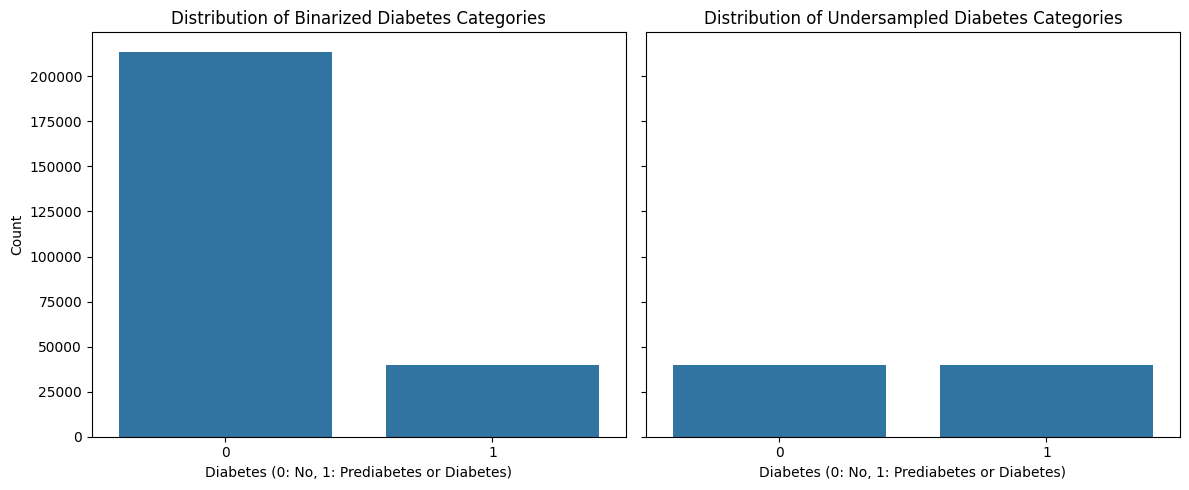

In [8]:
# Create subplots to visualize the distributions of the target variable
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot distribution of the binarized target
sns.countplot(ax=axes[0], x='y_binary', data=pd.DataFrame({'y_binary': y_binary}))
axes[0].set_title('Distribution of Binarized Diabetes Categories')
axes[0].set_xlabel('Diabetes (0: No, 1: Prediabetes or Diabetes)')
axes[0].set_ylabel('Count')

# Plot distribution of the undersampled target
sns.countplot(ax=axes[1], x='y_resampled', data=pd.DataFrame({'y_resampled': y_resampled}))
axes[1].set_title('Distribution of Undersampled Diabetes Categories')
axes[1].set_xlabel('Diabetes (0: No, 1: Prediabetes or Diabetes)')

plt.tight_layout()
plt.show()

Now that the target variable has been balanced, it's interesting to know how the target variable correlates with the features. For this, a **correlation matrix heatmap** will be generated.

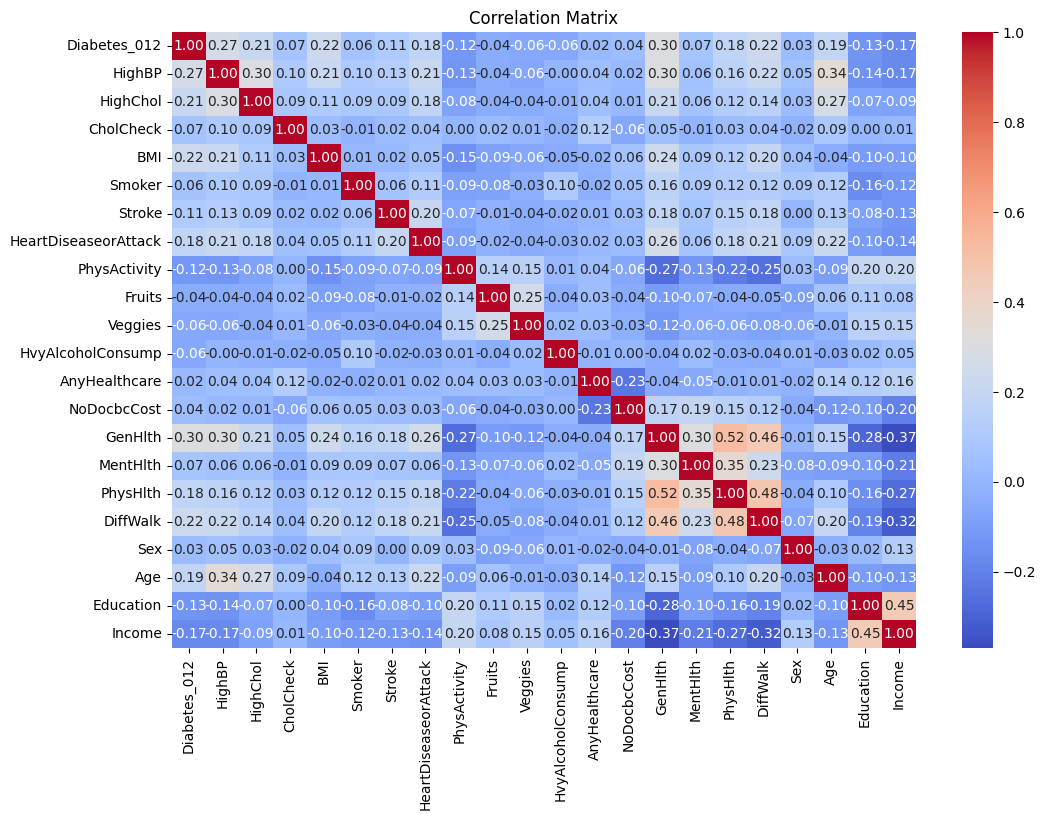

In [9]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows that the target variable `Diabetes_012` shows notable positive correlations with features like `HighBP`, `HighCol`, `BMI` and `Age`, indicating that these features are significant predictors for diabetes.

With these analysis elements, some of the most important features can be displayed in **pair plots**, in order to see the relationship between each feature and the target variable.

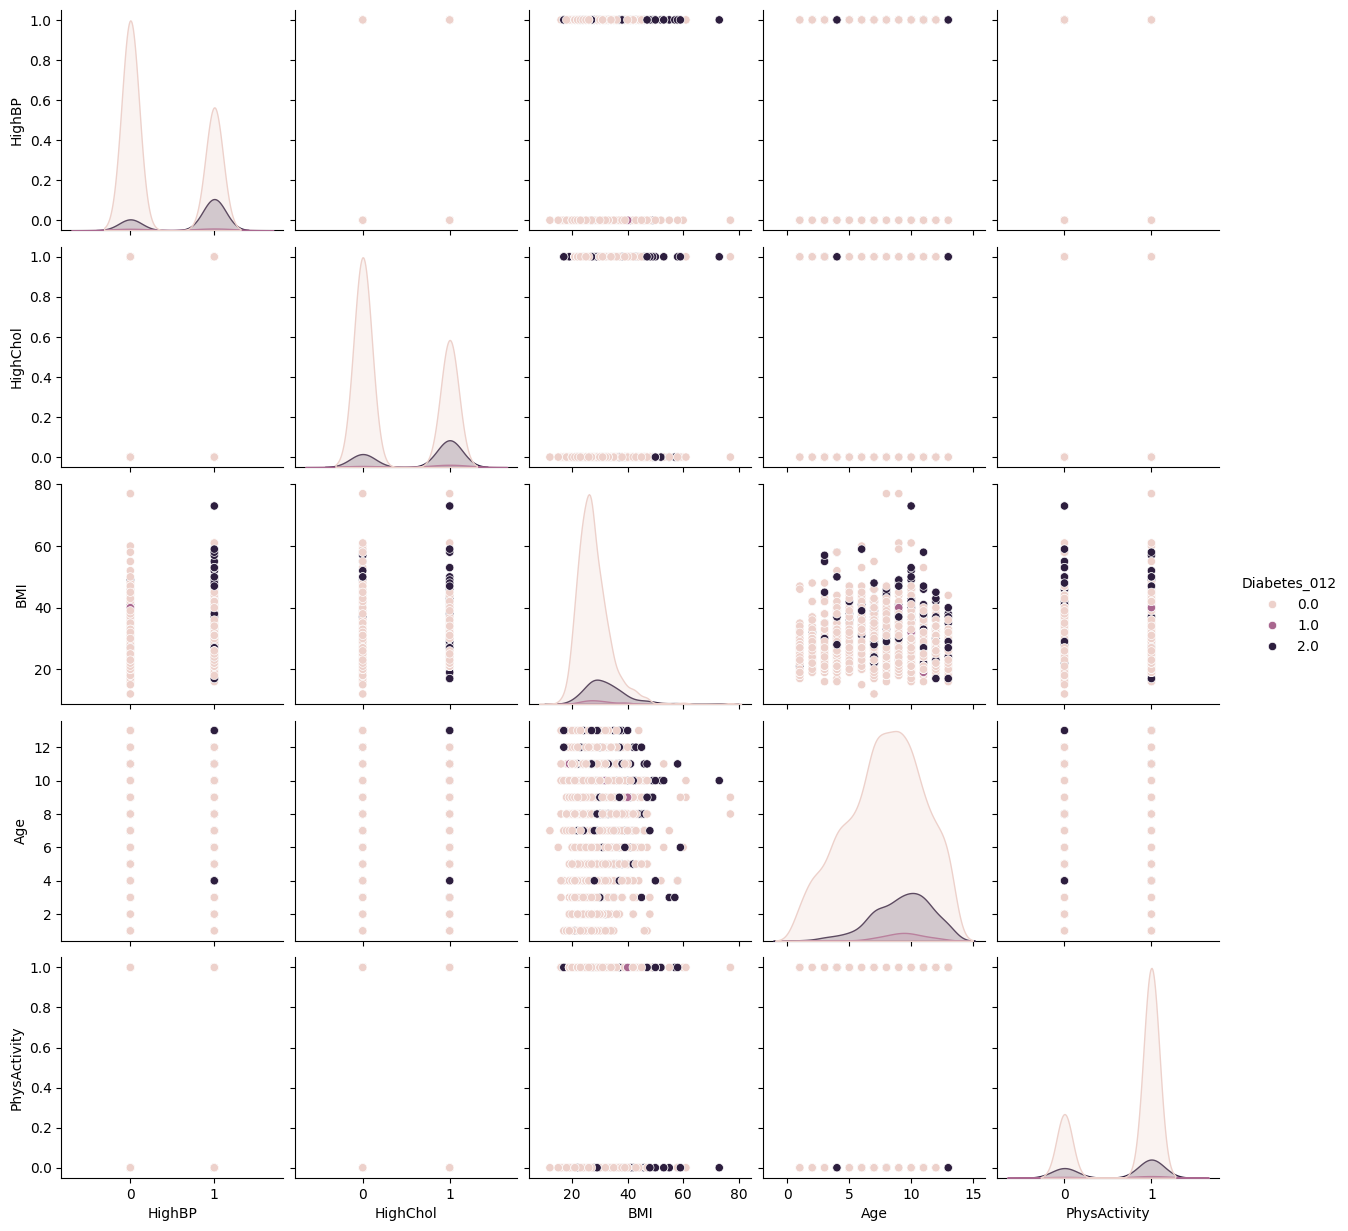

In [10]:
# Sample a subset of the data for faster plotting
sampled_df = df.sample(frac=0.01, random_state=42)  # 10% of the data

# Pair plot with sampled data
selected_features = ['HighBP', 'HighChol', 'BMI', 'Age', 'PhysActivity']
sns.pairplot(sampled_df[selected_features + ['Diabetes_012']], hue='Diabetes_012')
plt.show()

For the numerical features, such as `BMI`, `Age` and `Income` (based on the results from previous analysis) we can generate **Boxplots** and interpret the results.

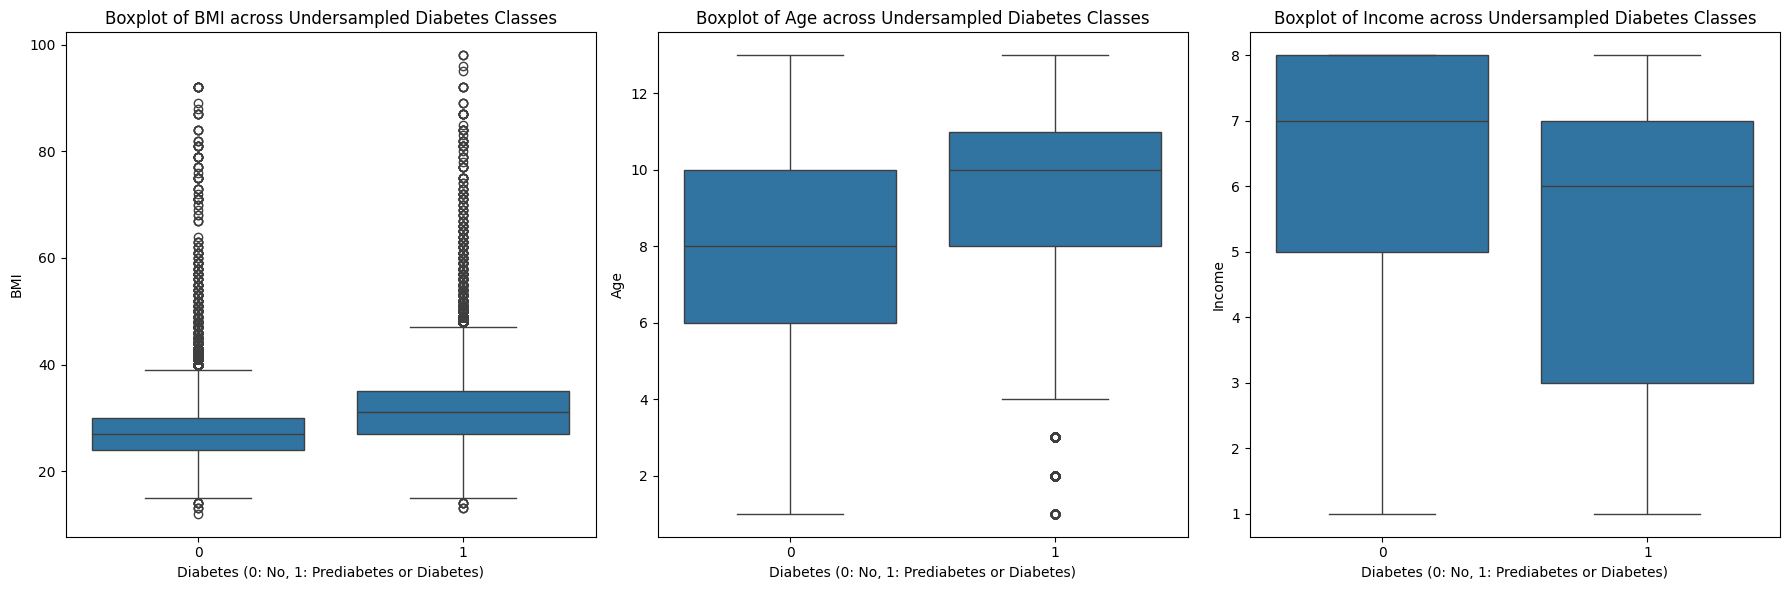

In [11]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
X_resampled_df['y_resampled'] = y_resampled

# List of selected features for the new plot
selected_features = ['BMI', 'Age', 'Income']

# Create subplots for selected features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, col in enumerate(selected_features):
    sns.boxplot(ax=axes[i], x='y_resampled', y=col, data=X_resampled_df)
    axes[i].set_title(f'Boxplot of {col} across Undersampled Diabetes Classes')
    axes[i].set_xlabel('Diabetes (0: No, 1: Prediabetes or Diabetes)')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

**Control-to-Treatment Ratio** with the target variable data, is important for the prediction model. So first, the standard control-to-treatment ratio can be calculated (or searched in the model library) and multiple experiments with different ratios were made by changing this control_to_treatment ratio.

In [12]:
# calculate control-to-treatment ratio
control_count = sum(y_resampled == 0)
treatment_count = sum(y_resampled == 1)

control_to_treatment_ratio = control_count / treatment_count
print(f"Control-to-Treatment Ratio: {control_to_treatment_ratio}")

Control-to-Treatment Ratio: 1.0


As a final analysis of the features, an **univariate logistic regression** can be implemented, and the resulting significant features can be compared to previous research and analysis.

In [13]:
# reset the index for both X_resampled and y_resampled to align indices
X_resampled = X_resampled.reset_index(drop=True)
y_resampled = pd.Series(y_resampled).reset_index(drop=True)

# standardize the X variables for univariate logistic regression
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)

# store the results from univariate logistic regressions
logit_results = {}

# perform univariate logistic regression for each feature
for column in X_scaled.columns:
    X_univariate = sm.add_constant(X_scaled[[column]])  # add constant for intercept
    model = sm.Logit(y_resampled, X_univariate).fit(disp=0)
    logit_results[column] = {
        'coef': model.params[1],
        'p-value': model.pvalues[1],
        'odds_ratio': np.exp(model.params[1])
    }

# convert results to a DataFrame for better readability
univariate_results = pd.DataFrame(logit_results).T.sort_values('p-value')
print("Top features from univariate analysis:")
print(univariate_results.head())

Top features from univariate analysis:
                          coef  p-value  odds_ratio
HighBP                0.780275      0.0    2.182072
HighChol              0.579220      0.0    1.784645
BMI                   0.714441      0.0    2.043044
PhysActivity         -0.312189      0.0    0.731844
HeartDiseaseorAttack  0.441510      0.0    1.555054


In [14]:
# feature selection based on p-values (p < 0.05)
significant_features = univariate_results[univariate_results['p-value'] < 0.05].index
print(f"Significant features selected: {significant_features}")

Significant features selected: Index(['HighBP', 'HighChol', 'BMI', 'PhysActivity', 'HeartDiseaseorAttack',
       'PhysHlth', 'GenHlth', 'DiffWalk', 'Income', 'Education', 'Age',
       'Stroke', 'CholCheck', 'MentHlth', 'Smoker', 'HvyAlcoholConsump',
       'Veggies', 'Fruits', 'NoDocbcCost', 'Sex', 'AnyHealthcare'],
      dtype='object')


Now, the **prediction models** can be implemented using these significant features.

In [22]:
# Use only significant features for the models
X_significant = X_scaled[significant_features]

# Define cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize dictionaries to store metrics for each model
metrics_rf = []
metrics_lr = []
metrics_gb = []

# Perform k-fold cross-validation
fold = 1
for train_idx, test_idx in cv.split(X_significant, y_resampled):
    X_train, X_test = X_significant.iloc[train_idx], X_significant.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

    metrics_rf.append({
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'ROC_AUC': roc_auc_score(y_test, y_proba_rf)
    })
    print(f"Fold {fold} - Random Forest: {metrics_rf[-1]}")

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    y_pred_lr = log_reg.predict(X_test)
    y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

    metrics_lr.append({
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr),
        'ROC_AUC': roc_auc_score(y_test, y_proba_lr)
    })
    print(f"Fold {fold} - Logistic Regression: {metrics_lr[-1]}")

    # Gradient Boosting
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

    metrics_gb.append({
        'Accuracy': accuracy_score(y_test, y_pred_gb),
        'Precision': precision_score(y_test, y_pred_gb),
        'ROC_AUC': roc_auc_score(y_test, y_proba_gb)
    })
    print(f"Fold {fold} - Gradient Boosting: {metrics_gb[-1]}")

    fold += 1

# Compute mean metrics for each model
mean_metrics_rf = pd.DataFrame(metrics_rf).mean().to_dict()
mean_metrics_lr = pd.DataFrame(metrics_lr).mean().to_dict()
mean_metrics_gb = pd.DataFrame(metrics_gb).mean().to_dict()

# Print average metrics for each model
print("\nModel Evaluation Metrics (Averaged Across Folds):")

print("\nRandom Forest:")
print(f"Accuracy: {mean_metrics_rf['Accuracy']:.4f}")
print(f"Precision: {mean_metrics_rf['Precision']:.4f}")
print(f"ROC-AUC: {mean_metrics_rf['ROC_AUC']:.4f}")

print("\nLogistic Regression:")
print(f"Accuracy: {mean_metrics_lr['Accuracy']:.4f}")
print(f"Precision: {mean_metrics_lr['Precision']:.4f}")
print(f"ROC-AUC: {mean_metrics_lr['ROC_AUC']:.4f}")

print("\nGradient Boosting:")
print(f"Accuracy: {mean_metrics_gb['Accuracy']:.4f}")
print(f"Precision: {mean_metrics_gb['Precision']:.4f}")
print(f"ROC-AUC: {mean_metrics_gb['ROC_AUC']:.4f}")


Fold 1 - Random Forest: {'Accuracy': 0.7317240948033269, 'Precision': np.float64(0.7154821449342794), 'ROC_AUC': np.float64(0.8022746676652899)}
Fold 1 - Logistic Regression: {'Accuracy': 0.7429804264899006, 'Precision': np.float64(0.7336701551786359), 'ROC_AUC': np.float64(0.8198486594767052)}
Fold 1 - Gradient Boosting: {'Accuracy': 0.7498592958539179, 'Precision': np.float64(0.7306315667936728), 'ROC_AUC': np.float64(0.8244780614197029)}
Fold 2 - Random Forest: {'Accuracy': 0.7315990244512538, 'Precision': np.float64(0.7175420044648102), 'ROC_AUC': np.float64(0.8020438846690388)}
Fold 2 - Logistic Regression: {'Accuracy': 0.7436683134263022, 'Precision': np.float64(0.7332934131736527), 'ROC_AUC': np.float64(0.8156862671485836)}
Fold 2 - Gradient Boosting: {'Accuracy': 0.7452942280032518, 'Precision': np.float64(0.7275469946623346), 'ROC_AUC': np.float64(0.8230148063400056)}
Fold 3 - Random Forest: {'Accuracy': 0.7285973360015009, 'Precision': np.float64(0.7152614225153086), 'ROC_AUC

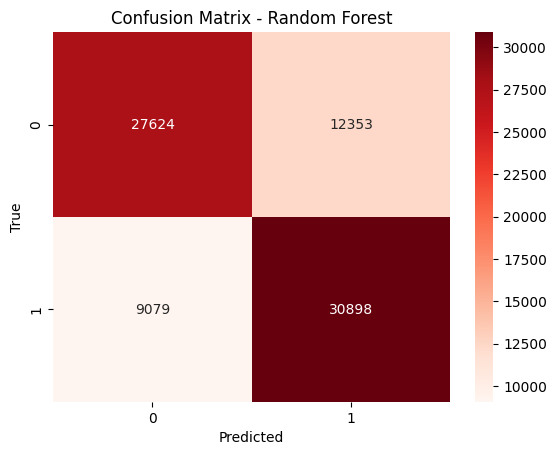

In [16]:
# confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_resampled, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

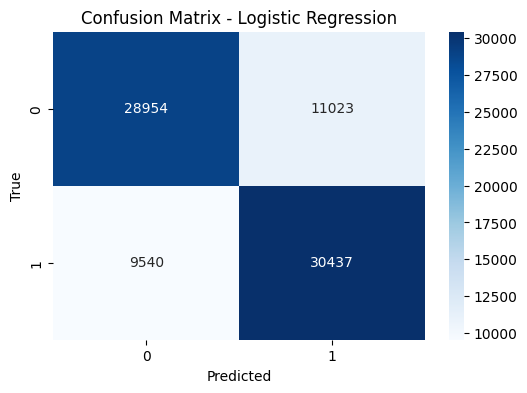

In [17]:
# confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_resampled, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

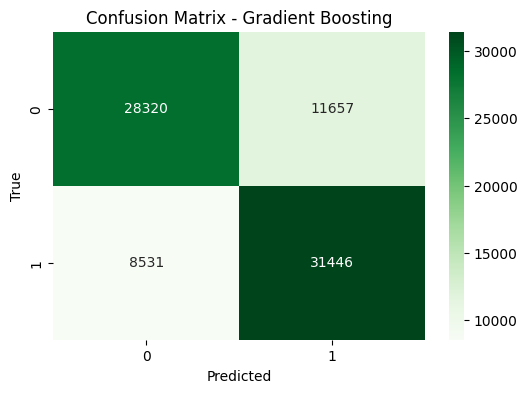

In [18]:
# confusion matrix for Gradient Boosting
conf_matrix_gb = confusion_matrix(y_resampled, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [19]:
# calculate ROC curve for each model
fpr_rf, tpr_rf, _ = roc_curve(y_resampled, y_pred_rf_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_resampled, y_pred_lr_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_resampled, y_pred_gb_proba)

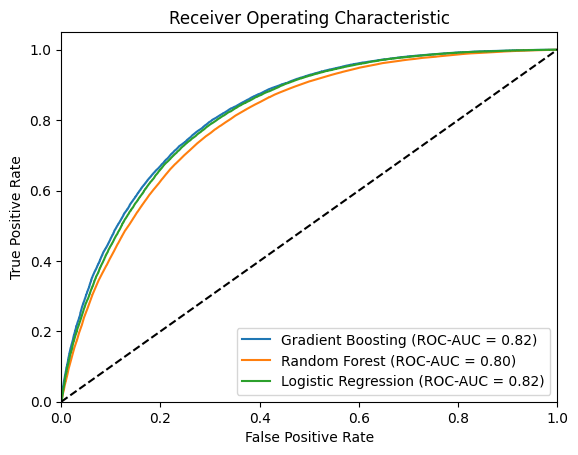

In [20]:
# plot ROC Curves
plt.plot(fpr_gb, tpr_gb, label="Gradient Boosting (ROC-AUC = %0.2f)" % roc_auc_gb)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (ROC-AUC = %0.2f)" % roc_auc_rf)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (ROC-AUC = %0.2f)" % roc_auc_lr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()